In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet #from version 1.0 package name was changed from prophet to prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


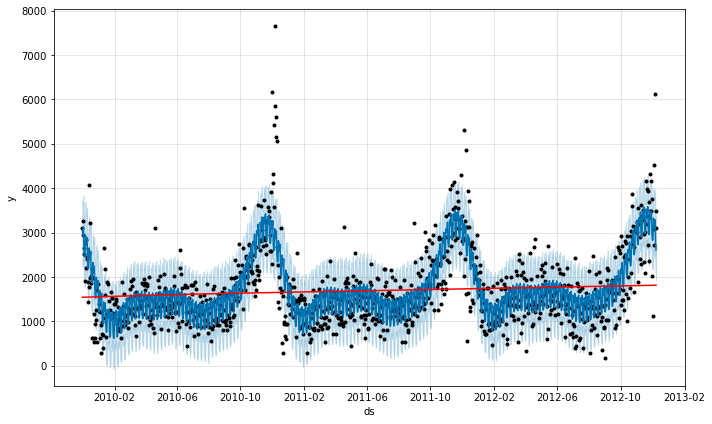

In [2]:
df = pd.read_csv('../data/online_retail.csv')
df.columns = ['ds', 'y']

model = Prophet(yearly_seasonality=4)
model.fit(df)
forecast = model.predict()
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

In [3]:
df_cv = cross_validation(model,
                         horizon='90 days',
                         period='30 days',
                         initial='730 days',
                         parallel='processes')

INFO:prophet:Making 10 forecasts with cutoffs between 2011-12-14 00:00:00 and 2012-09-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000026728D0F688>


In [4]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon            mse        rmse         mae      mape     mdape  coverage
0  9 days  221414.637261  470.547168  379.222017  0.300342  0.230643  0.866667
1 10 days  217886.528127  466.783170  374.813252  0.297143  0.223107  0.877778
2 11 days  202750.966319  450.278765  368.159469  0.287512  0.204026  0.900000
3 12 days  178915.164185  422.983645  350.389468  0.273400  0.209786  0.922222
4 13 days  172812.883168  415.707690  344.207267  0.260578  0.190466  0.933333

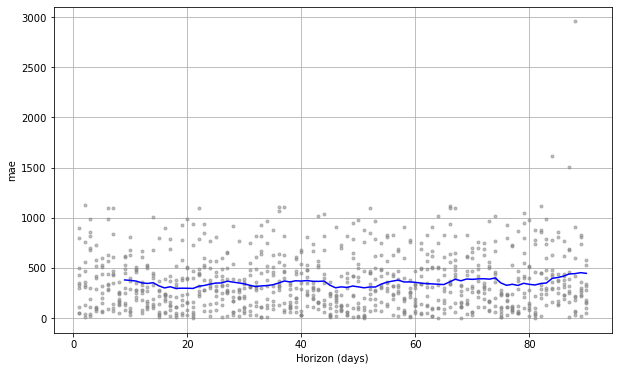

In [5]:
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()

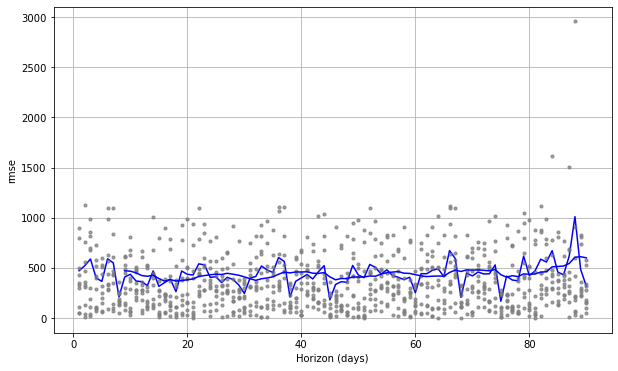

In [6]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.01,
                             ax=ax)
plot_cross_validation_metric(df_cv,
                             metric='rmse',
                             rolling_window=.1,
                             ax=ax)
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


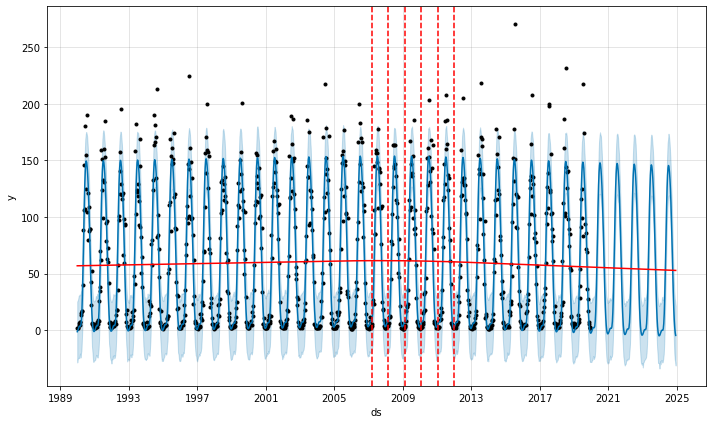

In [7]:
df = pd.read_csv('../data/rainfall.csv')
df.columns = ['ds', 'y']

model = Prophet(yearly_seasonality=4)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 5)
future = future[future['ds'].dt.day.isin([1, 11, 21])]
forecast = model.predict(future)
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

INFO:prophet:Making 302 forecasts with cutoffs between 1995-01-01 00:00:00 and 2019-09-22 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002672D5CCC08>


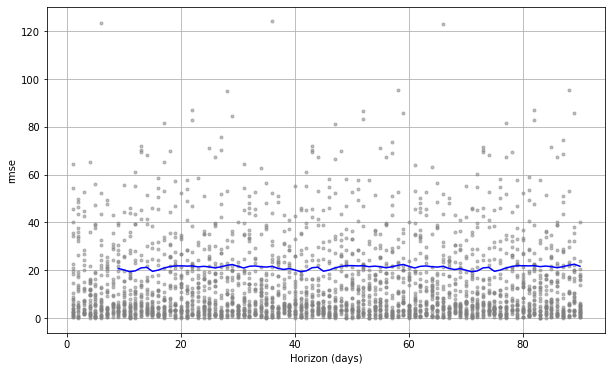

In [8]:
df_cv = cross_validation(model,
                         horizon='90 days',
                         period='30 days',
                         initial='1826 days',
                         parallel='processes')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

In [9]:
cutoffs = [pd.Timestamp('{}-{}-{}'.format(year, month, day))
           for year in range(2005, 2019)
           for month in range(1, 13)
           for day in [1, 11, 21]]

INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002672BA49C08>


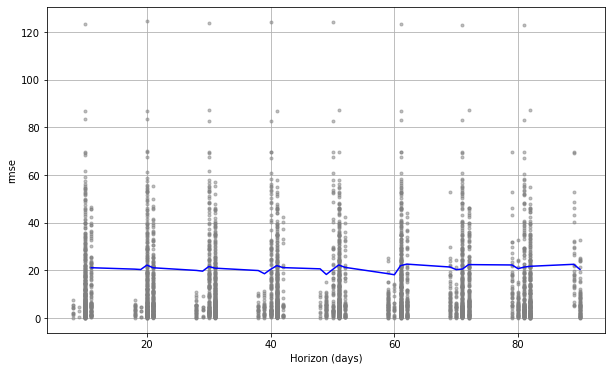

In [10]:
df_cv = cross_validation(model,
                         horizon='90 days',
                         parallel='processes',
                         cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

In [11]:
param_grid = {'changepoint_prior_scale': [0.5, 0.1, 0.01, 0.001],
              'seasonality_prior_scale': [10.0, 1.0, 0.1, 0.01],
              'seasonality_mode': ['additive', 'multiplicative']}

In [12]:
import numpy as np
import itertools

all_params = [dict(zip(param_grid.keys(), value))
              for value in itertools.product(*param_grid.values())]
rmse_values= []

In [13]:
cutoffs = [pd.Timestamp('{}-{}-{}'.format(year, month, day))
           for year in range(2010, 2019)
           for month in range(1, 13)
           for day in [1, 11, 21]]

In [14]:
for params in all_params:
    model = Prophet(yearly_seasonality=4, **params).fit(df)
    df_cv = cross_validation(model,
                             cutoffs=cutoffs,
                             horizon='30 days',
                             parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmse_values.append(df_p['rmse'].values[0])

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002672B8B0AC8>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002672D950348>
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x000002672856D508>
INFO:prophet:Disabling weekly seasonality. 

In [15]:
results = pd.DataFrame(all_params)
results['rmse'] = rmse_values
results.head()

changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                      0.5                     10.0         additive   
1                      0.5                     10.0   multiplicative   
2                      0.5                      1.0         additive   
3                      0.5                      1.0   multiplicative   
4                      0.5                      0.1         additive   

        rmse  
0  22.621225  
1  23.044739  
2  22.622803  
3  23.054798  
4  22.631216

In [16]:
best_params = all_params[np.argmin(rmse_values)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}
